## Parse data

In [1]:
import sys
import os

# Get the absolute path to the project root directory
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the project root directory to the Python path
if root_path not in sys.path:
    sys.path.insert(0, root_path)

import yaml
from glob import glob
from tqdm.auto import tqdm
from collections import defaultdict
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)

# Collect results grouped by config (excluding seed)
results_by_config = defaultdict(list)

for path in tqdm(glob("../training-results-symbolic/*/results.yaml")):
    with open(path, "r") as f:
        results = yaml.safe_load(f)

    test_mean = results["test_score"]["mean"]

    with open(path.replace("results.yaml", "train.yaml")) as f:
        hp = yaml.safe_load(f)

    room_size = hp["env_config"]["room_size"]
    qa_policy = hp["qa_policy"]
    explore_policy = hp["explore_policy"]
    forget_policy = hp.get("forget_policy", None)
    remember_policy = hp.get("remember_policy", "all")
    memory_size = hp.get("max_long_term_memory_size", None)

    config_key = (
        room_size,
        qa_policy,
        explore_policy,
        forget_policy,
        remember_policy,
        memory_size,
    )
    results_by_config[config_key].append(test_mean)

# Build a DataFrame from the aggregated results
records = []
for config, scores in sorted(results_by_config.items()):
    (
        room_size,
        qa_policy,
        explore_policy,
        forget_policy,
        remember_policy,
        memory_size,
    ) = config
    records.append(
        {
            "room_size": room_size,
            "mean_score": np.mean(scores),
            "std_score": np.std(scores),
            "qa_policy": qa_policy,
            "explore_policy": explore_policy,
            "forget_policy": forget_policy,
            "remember_policy": remember_policy,
            "memory_size": memory_size,
            "n_seeds": len(scores),
        }
    )

df = pd.DataFrame(records)
pd.set_option("display.precision", 4)

# Filter for the specific room size
room_filter = "xl-different-prob"
df_filtered = df[df["room_size"] == room_filter].drop(columns="room_size")

# Create separate DataFrames for each memory size
memory_sizes = sorted(df_filtered["memory_size"].unique())
dataframes_by_memory = {}

print(f"Creating {len(memory_sizes)} DataFrames for memory sizes: {memory_sizes}")
print("=" * 80)

for memory_size in memory_sizes:
    # Filter data for this specific memory size
    memory_df = df_filtered[df_filtered["memory_size"] == memory_size].drop(
        columns="memory_size"
    )
    # Sort by mean_score in descending order
    memory_df = memory_df.sort_values(by="mean_score", ascending=False).reset_index(
        drop=True
    )

    # Store in dictionary
    dataframes_by_memory[memory_size] = memory_df

    # Display the DataFrame
    print(f"\n=== DataFrame for Memory Size: {memory_size} ===")
    print()
    display(memory_df)
    print("-" * 80)

# Summary statistics
print(f"\n=== SUMMARY ===")
print(f"Total number of memory sizes: {len(memory_sizes)}")
print(f"Memory sizes analyzed: {memory_sizes}")


# Find best configuration across all memory sizes
best_overall = df_filtered.loc[df_filtered["mean_score"].idxmax()]
print(f"\nBest overall configuration:")
print(f"  Memory Size: {best_overall['memory_size']}")
print(f"  QA Policy: {best_overall['qa_policy']}")
print(f"  Explore Policy: {best_overall['explore_policy']}")
print(f"  MM Forget Policy: {best_overall['forget_policy']}")
print(f"  MM Remember Policy: {best_overall['remember_policy']}")
print(f"  Score: {best_overall['mean_score']:.4f} ± {best_overall['std_score']:.4f}")

# Export each memory size DataFrame to separate files
print(f"\n=== EXPORTING FILES ===")

# # Export global results (all data for the room size, sorted by mean_score)
global_section = df_filtered.sort_values(by="mean_score", ascending=False).reset_index(
    drop=True
)
global_filename = f"../data/results_xl-different-prob.json"
global_section.to_json(global_filename, orient="records", indent=2)
print(f"Global results for xl-different-prob exported to {global_filename}")

/home/tk/.virtualenvs/gnn-agent-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2639/2639 [00:01<00:00, 1456.88it/s]

Creating 11 DataFrames for memory sizes: [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

=== DataFrame for Memory Size: 0 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,32.6,10.9654,most_frequently_used,bfs,lfu,all,5
1,32.6,10.9654,most_frequently_used,bfs,lru,all,5
2,32.6,10.9654,most_frequently_used,dijkstra,lru,all,5
3,32.6,10.9654,most_frequently_used,dijkstra,lfu,all,5
4,32.6,10.9654,most_recently_added,bfs,lfu,all,5
5,32.6,10.9654,most_recently_added,bfs,lru,all,5
6,32.6,10.9654,random,dijkstra,lru,all,5
7,32.6,10.9654,random,dijkstra,lfu,all,5
8,32.6,10.9654,random,bfs,lru,all,5
9,32.6,10.9654,random,bfs,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 2 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,106.8,31.8207,random,bfs,lfu,all,5
1,98.0,39.1357,most_frequently_used,bfs,lfu,all,5
2,98.0,39.1357,most_recently_used,bfs,lfu,all,5
3,75.4,30.7024,most_recently_added,bfs,lfu,all,5
4,70.0,50.9313,random,dijkstra,lfu,all,5
5,58.4,32.8244,most_frequently_used,dijkstra,lfu,all,5
6,57.8,34.4465,most_recently_used,dijkstra,lfu,all,5
7,53.6,33.3143,most_recently_added,dijkstra,lfu,all,5
8,52.0,19.0263,most_recently_used,bfs,lru,all,5
9,52.0,19.0263,most_frequently_used,bfs,lru,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 4 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,162.0,67.7761,most_frequently_used,bfs,lfu,all,5
1,160.6,68.8581,most_recently_used,bfs,lfu,all,5
2,158.6,65.1110,most_recently_added,bfs,lfu,all,5
3,134.0,40.3534,random,bfs,lfu,all,5
4,99.0,40.9732,most_frequently_used,dijkstra,lfu,all,5
5,94.2,57.1258,most_recently_added,dijkstra,lfu,all,5
6,87.4,19.2208,most_recently_used,dijkstra,lfu,all,5
7,87.4,50.2896,random,dijkstra,lfu,all,5
8,85.0,33.7580,most_frequently_used,random,lfu,all,5
9,83.4,14.2352,most_recently_added,random,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 8 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,311.4,42.6033,most_frequently_used,bfs,lfu,all,5
1,295.0,69.7746,random,bfs,lfu,all,4
2,277.8,84.1793,most_recently_used,bfs,lfu,all,5
3,276.4,32.6411,most_recently_used,dijkstra,lfu,all,5
4,271.4,68.3479,random,dijkstra,lfu,all,5
5,251.2,74.3650,most_frequently_used,dijkstra,lfu,all,5
6,240.2,74.9250,most_recently_added,bfs,lfu,all,5
7,180.4,63.3296,most_recently_added,dijkstra,lfu,all,5
8,168.4,16.3291,random,dijkstra,lru,all,5
9,165.8,36.7663,random,bfs,lru,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 16 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,362.2,92.0595,random,bfs,lfu,all,5
1,353.6,115.6868,most_recently_added,bfs,lfu,all,5
2,350.6,45.4031,most_frequently_used,bfs,lfu,all,5
3,337.6,61.5097,most_recently_used,bfs,lfu,all,5
4,332.0,34.6006,random,dijkstra,lru,all,5
5,328.4,128.9443,random,dijkstra,lfu,all,5
6,310.4,42.7486,most_recently_used,dijkstra,lru,all,5
7,301.2,75.7559,most_frequently_used,dijkstra,lfu,all,5
8,295.2,29.6877,most_recently_added,bfs,lru,all,5
9,283.6,116.2439,most_frequently_used,random,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 32 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,528.8,28.9786,most_recently_used,bfs,lfu,all,5
1,512.2,56.9189,most_frequently_used,bfs,lfu,all,5
2,490.0,52.8432,random,bfs,lfu,all,5
3,485.4,21.0580,most_recently_used,bfs,lru,all,5
4,482.6,41.7833,most_recently_added,dijkstra,lru,all,5
5,478.8,63.3574,most_recently_used,dijkstra,lru,all,5
6,467.4,20.2840,most_recently_added,bfs,lru,all,5
7,446.8,38.1125,random,bfs,lru,all,5
8,444.6,18.1505,most_frequently_used,bfs,lru,all,5
9,428.0,70.3420,most_recently_added,bfs,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 64 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,623.8,46.0973,most_recently_used,bfs,lru,all,5
1,614.4,51.2273,most_recently_used,dijkstra,lru,all,5
2,608.4,49.2203,most_recently_used,bfs,lfu,all,5
3,598.4,26.4167,most_recently_added,dijkstra,lru,all,5
4,594.4,33.4102,most_recently_added,dijkstra,lfu,all,5
5,586.6,45.8327,most_recently_added,bfs,lfu,all,5
6,583.4,46.3448,most_frequently_used,bfs,lfu,all,5
7,568.4,27.0599,most_recently_added,bfs,lru,all,5
8,566.6,25.0488,random,bfs,lfu,all,5
9,555.4,43.6147,random,dijkstra,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 128 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,641.8,65.5726,most_recently_added,dijkstra,lru,all,5
1,633.8,43.9017,most_recently_added,bfs,lru,all,5
2,631.2,60.9373,most_recently_added,dijkstra,lfu,all,5
3,630.0,43.6119,most_recently_used,bfs,lru,all,5
4,607.2,57.5757,most_recently_used,bfs,lfu,all,5
5,603.4,60.7441,most_recently_added,bfs,lfu,all,5
6,596.6,56.4220,random,bfs,lfu,all,5
7,588.6,44.4999,random,bfs,lru,all,5
8,586.0,38.8999,random,dijkstra,lru,all,5
9,584.2,72.4276,most_recently_used,dijkstra,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 256 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,650.2,22.5335,most_recently_added,dijkstra,lru,all,5
1,649.6,34.9949,most_recently_added,bfs,lfu,all,5
2,648.8,38.6544,most_recently_added,bfs,lru,all,5
3,633.4,29.8436,random,bfs,lru,all,5
4,628.2,33.7010,most_recently_added,dijkstra,lfu,all,5
5,622.8,33.3311,most_recently_added,bfs,fifo,all,5
6,618.8,42.2724,random,dijkstra,lfu,all,5
7,615.6,47.7100,most_recently_added,bfs,random,all,5
8,612.0,31.1833,random,bfs,lfu,all,5
9,609.8,40.2313,most_recently_used,dijkstra,lfu,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 512 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,641.8,27.0658,most_recently_added,dijkstra,random,all,5
1,641.4,27.6810,most_recently_added,dijkstra,lru,all,5
2,640.6,27.5942,most_recently_added,dijkstra,lfu,all,5
3,639.8,26.2480,most_recently_added,dijkstra,fifo,all,5
4,637.6,21.2283,most_recently_added,bfs,random,all,5
5,635.8,21.5258,most_recently_added,bfs,fifo,all,5
6,633.2,19.7525,most_recently_added,bfs,lru,all,5
7,632.8,20.1336,most_recently_added,bfs,lfu,all,5
8,611.0,48.0541,most_recently_used,bfs,random,all,5
9,610.8,49.7811,most_recently_used,bfs,lru,all,5


--------------------------------------------------------------------------------

=== DataFrame for Memory Size: 1024 ===



,mean_score,std_score,qa_policy,explore_policy,mm_forget_policy,mm_remember_policy,n_seeds
0,644.2,31.4795,most_recently_added,dijkstra,random,all,5
1,644.2,31.4795,most_recently_added,dijkstra,lru,all,5
2,644.2,31.4795,most_recently_added,dijkstra,lfu,all,5
3,644.2,31.4795,most_recently_added,dijkstra,fifo,all,5
4,638.8,22.5690,most_recently_added,bfs,fifo,all,5
5,638.8,22.5690,most_recently_added,bfs,lfu,all,5
6,638.8,22.5690,most_recently_added,bfs,lru,all,5
7,638.8,22.5690,most_recently_added,bfs,random,all,5
8,614.0,49.6548,most_recently_used,bfs,fifo,all,5
9,614.0,49.6548,most_recently_used,bfs,lfu,all,5


--------------------------------------------------------------------------------

=== SUMMARY ===
Total number of memory sizes: 11
Memory sizes analyzed: [0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

Best overall configuration:
  Memory Size: 256
  QA Policy: most_recently_added
  Explore Policy: dijkstra
  MM Forget Policy: lru
  MM Remember Policy: all
  Score: 650.2000 ± 22.5335

=== EXPORTING FILES ===
Global results for xl-different-prob exported to ../data/results_xl-different-prob.json


## Draw plots

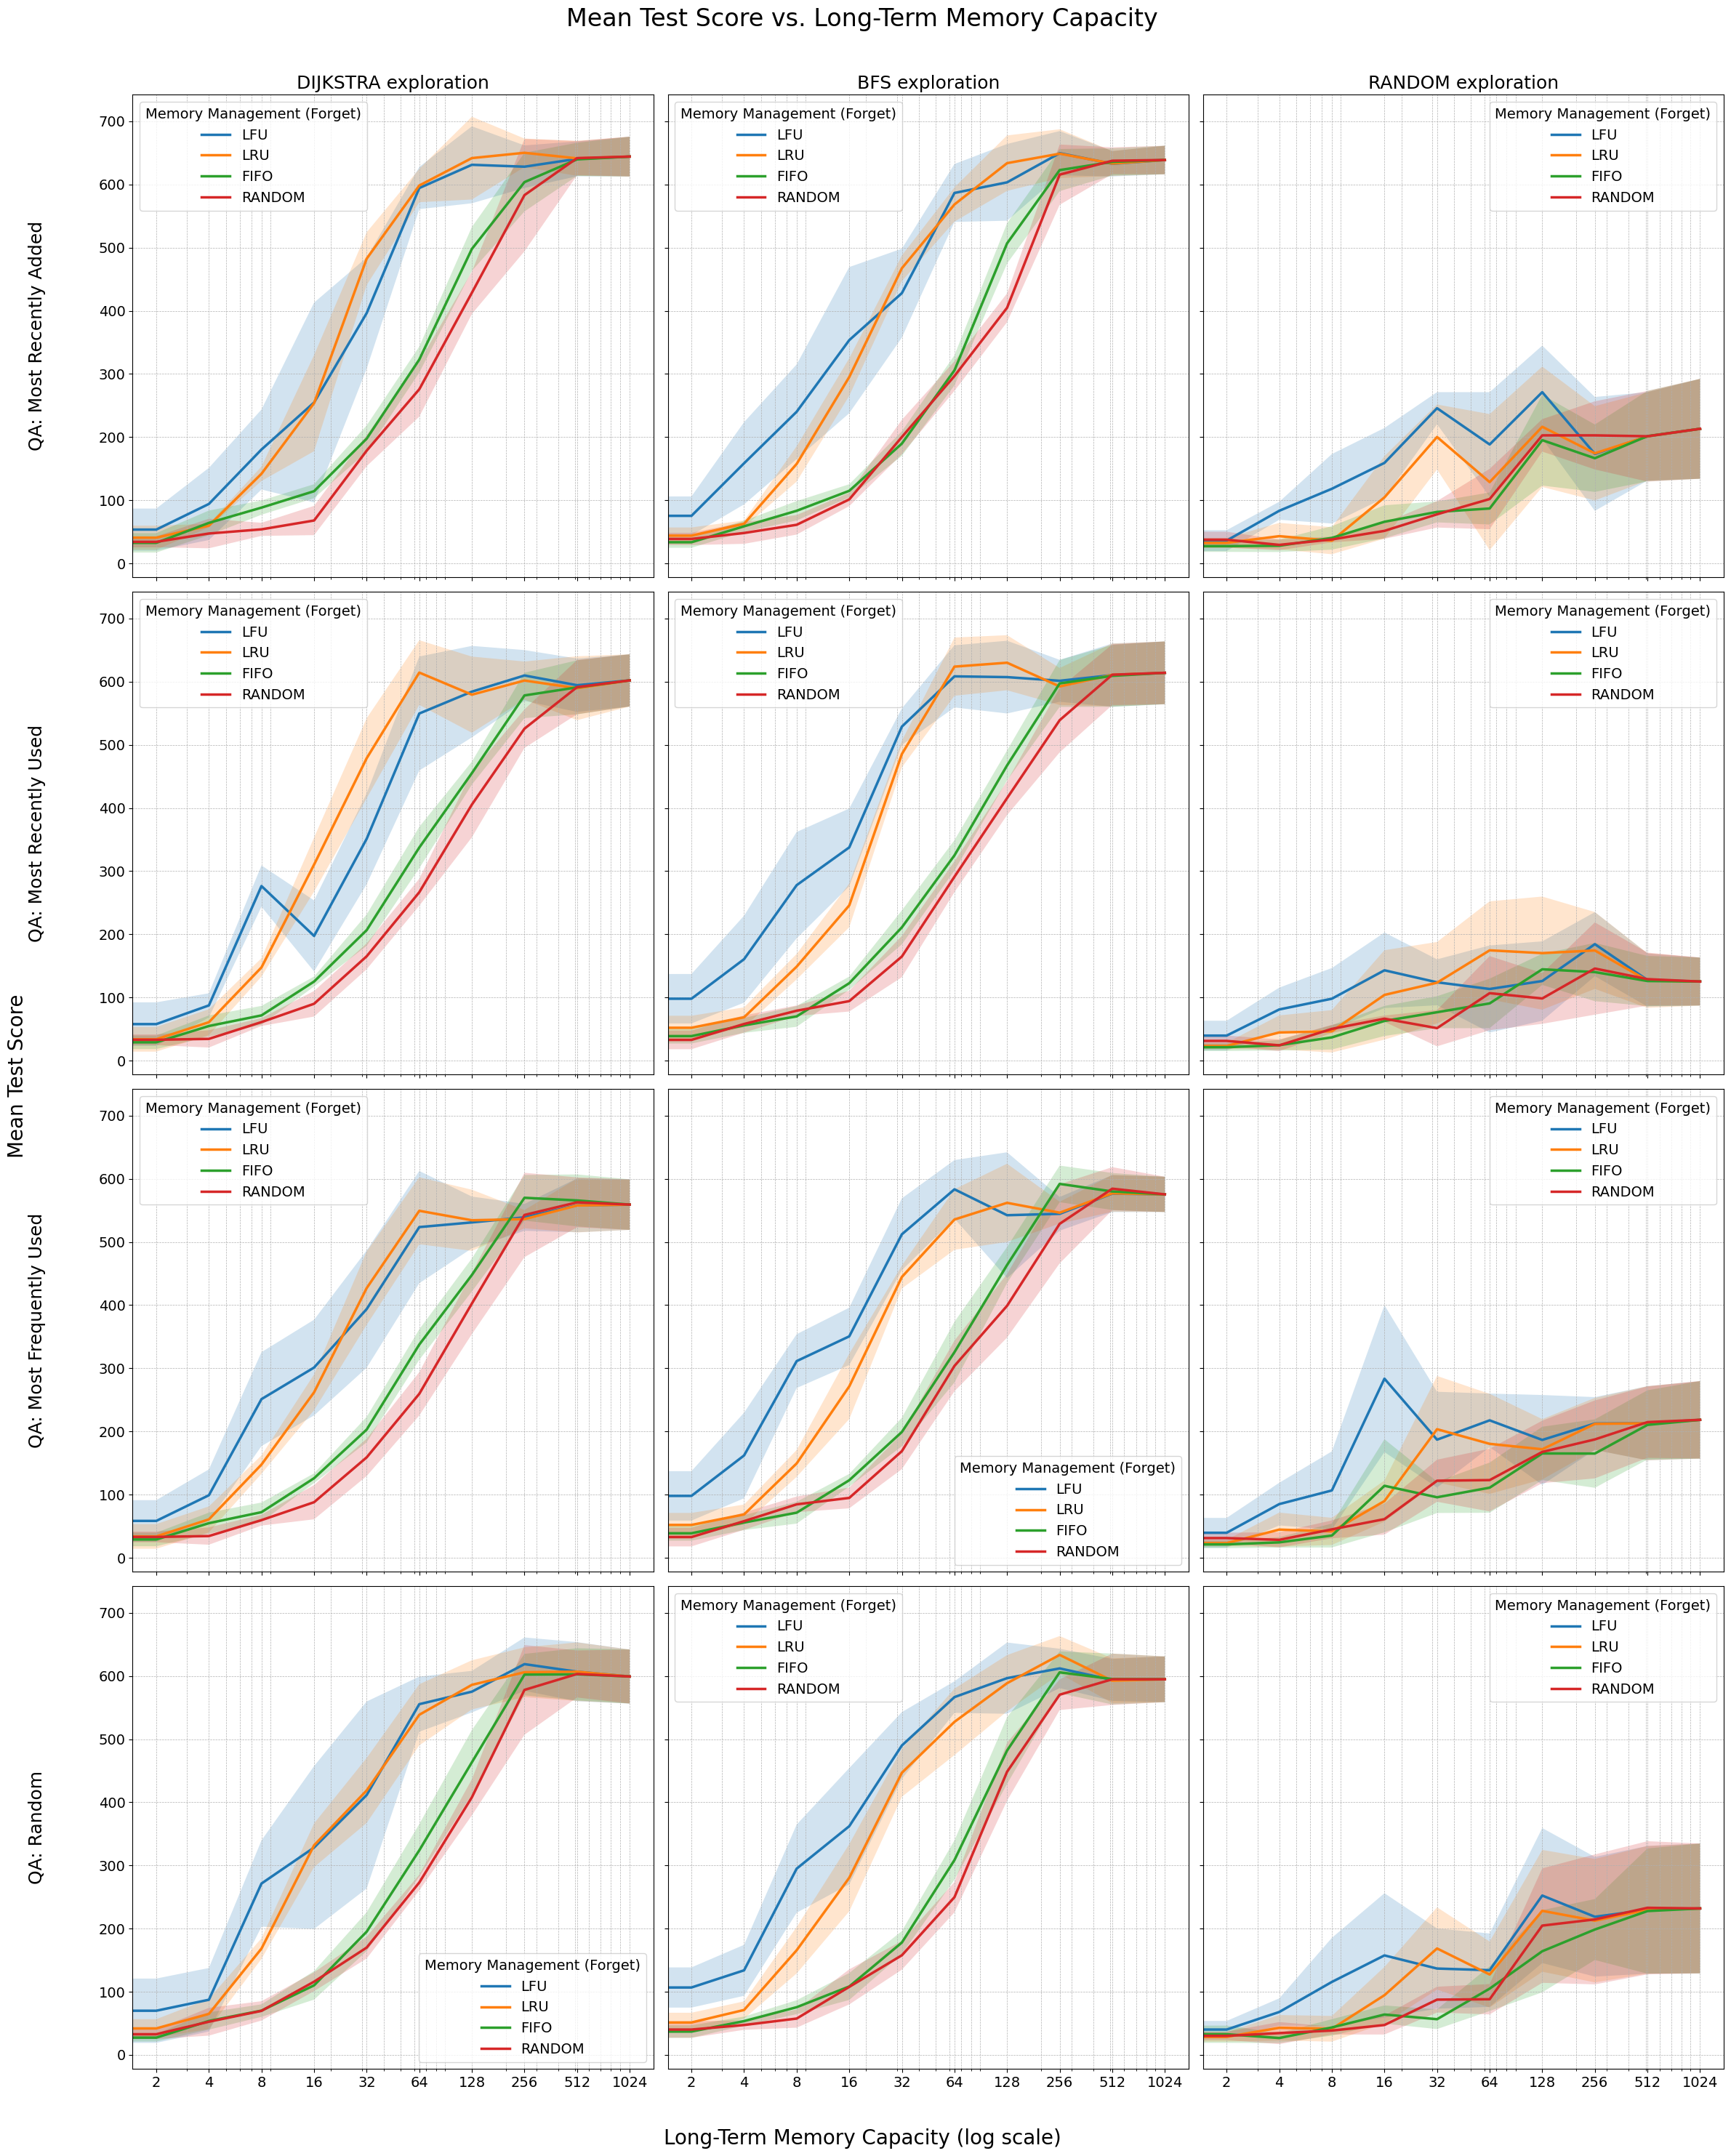

In [ ]:
import sys
import os

# Get the absolute path to the project root directory
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root directory to the Python path
if root_path not in sys.path:
    sys.path.insert(0, root_path)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json

# === CONFIGURATION ===
file_path = "../data/results_xl-different-prob.json"
include_shading = True   # Toggle shading for std deviation
log_xaxis = True
log_yaxis = False
line_width = 2.5
# ======================

# Load and prepare data
with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df = df.sort_values(by=["qa_policy", "explore_policy", "forget_policy", "memory_size"])

qa_policies = ["most_recently_added", "most_recently_used", "most_frequently_used", "random"]
explore_policies = ["dijkstra", "bfs", "random"]
mm_policies = ["lfu", "lru", "fifo", "random"]

# Create 4×3 subplot grid (4 QA policies × 3 exploration policies)
fig, axes = plt.subplots(4, 3, figsize=(24, 30), sharex=True, sharey=True)

for i, qa_policy in enumerate(qa_policies):
    for j, explore_policy in enumerate(explore_policies):
        ax = axes[i, j]
        for forget_policy in mm_policies:
            sub_df = df[
                (df["qa_policy"] == qa_policy)
                & (df["explore_policy"] == explore_policy)
                & (df["forget_policy"] == forget_policy)
            ]
            if len(sub_df) > 0:  # Check if data exists for this combination
                x = sub_df["memory_size"]
                y = sub_df["mean_score"]
                yerr = sub_df["std_score"]

                ax.plot(x, y, label=forget_policy.upper(), linewidth=line_width)
                if include_shading:
                    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Format only the first row and the first column for titles
        if i == 0:
            ax.set_title(f"{explore_policy.upper()} exploration", fontsize=18)
        if j == 0:
            ax.text(-0.2, 0.5, f"QA: {qa_policy.replace('_', ' ').title()}", 
                    rotation=90, transform=ax.transAxes, fontsize=18, 
                    verticalalignment='center')

        # Add legend to each subplot
        ax.legend(title="Memory Management (Forget)", fontsize=14, title_fontsize=14, loc="best")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.tick_params(axis="both", which="major", labelsize=14)

        if log_xaxis:
            ax.set_xscale("log")
            ax.set_xticks([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
            ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

        if log_yaxis:
            ax.set_yscale("log")
            ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=None))
            ax.yaxis.set_minor_locator(ticker.NullLocator())
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Shared axis labels
fig.text(
    0.5,
    0.01,
    "Long-Term Memory Capacity" + (" (log scale)" if log_xaxis else ""),
    ha="center",
    fontsize=20,
)
fig.text(
    0.01,
    0.5,
    "Mean Test Score" + (" (log scale)" if log_yaxis else ""),
    va="center",
    rotation="vertical",
    fontsize=20,
)
fig.suptitle("Mean Test Score vs. Long-Term Memory Capacity", fontsize=24, y=0.99)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.98])
plt.savefig("../figures/agent_test_performance.pdf", bbox_inches="tight")
plt.savefig("../figures/agent_test_performance.png", bbox_inches="tight")
plt.show()

## Make markdown table

In [ ]:
def generate_memory_table(data, qa_policy, explore_policy, forget_policy):
    """
    Generate a markdown table showing memory size and scores for a specific configuration

    Parameters:
    -----------
    data : list of dicts
        The loaded results data
    qa_policy : str
        Question answering policy (e.g., "most_frequently_used")
    explore_policy : str
        Exploration policy (e.g., "bfs")
    forget_policy : str
        Forget Memory management policy (e.g., "lfu")

    Returns:
    --------
    str
        Formatted markdown table
    """
    # Filter the data
    filtered_data = [
        item
        for item in data
        if item["qa_policy"] == qa_policy
        and item["explore_policy"] == explore_policy
        and item["forget_policy"] == forget_policy
    ]

    # Sort by memory_size for better readability
    filtered_data = sorted(filtered_data, key=lambda x: x["memory_size"])

    # Generate markdown table
    markdown_lines = []
    markdown_lines.append(
        f"*Configuration: QA Policy = {qa_policy}, Explore Policy = {explore_policy}, MM Long Policy = {forget_policy}*\n"
    )

    markdown_lines.append("| Memory Size | Mean Score (± Std) |")
    markdown_lines.append("|-------------|-------------------|")

    for item in filtered_data:
        memory_size = item["memory_size"]
        mean_score = item["mean_score"]
        std_score = f"{round(item['std_score'])}"

        markdown_lines.append(f"| {memory_size} | {mean_score} (± {std_score}) |")

    # Return the markdown
    return "\n".join(markdown_lines)

In [5]:
print(generate_memory_table(data, "most_recently_added", "dijkstra", "lru"))

*Configuration: QA Policy = most_recently_added, Explore Policy = dijkstra, MM Long Policy = lru*

| Memory Size | Mean Score (± Std) |
|-------------|-------------------|
| 0 | 32.6 (± 11) |
| 2 | 40.8 (± 19) |
| 4 | 59.8 (± 3) |
| 8 | 142.0 (± 11) |
| 16 | 253.8 (± 76) |
| 32 | 482.6 (± 42) |
| 64 | 598.4 (± 26) |
| 128 | 641.8 (± 66) |
| 256 | 650.2 (± 23) |
| 512 | 641.4 (± 28) |
| 1024 | 644.2 (± 31) |
